In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d

0.19970703125
-0.19970703125


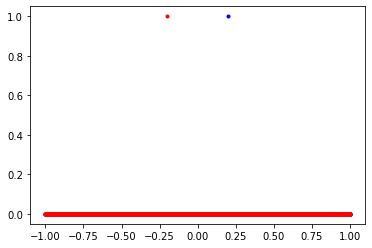

In [2]:
t = telescope_1d.Telescope1D(Npix=2**12)

# Sky with point source at alpha
image1 = t.empty_image()
ndx1 = int(t.Npix*60/100)
image1[ndx1] = 1

# Point source at negative alpha
image2 = t.empty_image()
ndx2 = -1*ndx1-1
image2[ndx2] = 1

# Confirm that the indices are right
print(t.alpha[ndx1])
print(t.alpha[ndx2])

plt.plot(t.alpha,image1,'b.')
plt.plot(t.alpha,image2,'r.')
plt.show()

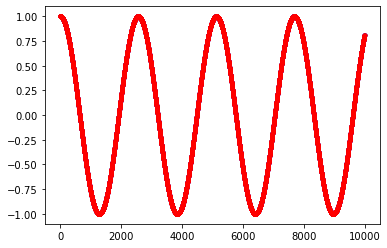

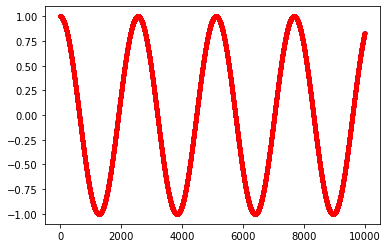

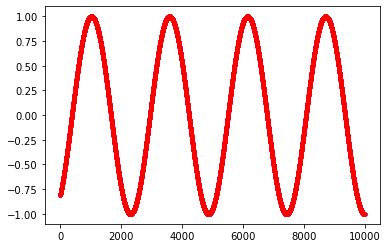

In [3]:
uv1 = t.image2uv(image1)
uv2 = t.image2uv(image2)

# Real part should be the same
plt.plot(np.real(uv1)[:10000],'b.')
plt.plot(np.real(uv2)[:10000],'r.')
plt.show()

plt.plot(np.real(uv1)[100000:100000+10000],'b.')
plt.plot(np.real(uv2)[100000:100000+10000],'r.')
plt.show()

plt.plot(np.real(uv1)[-10000:],'b.')
plt.plot(np.real(uv2)[-10000:],'r.')
plt.show()

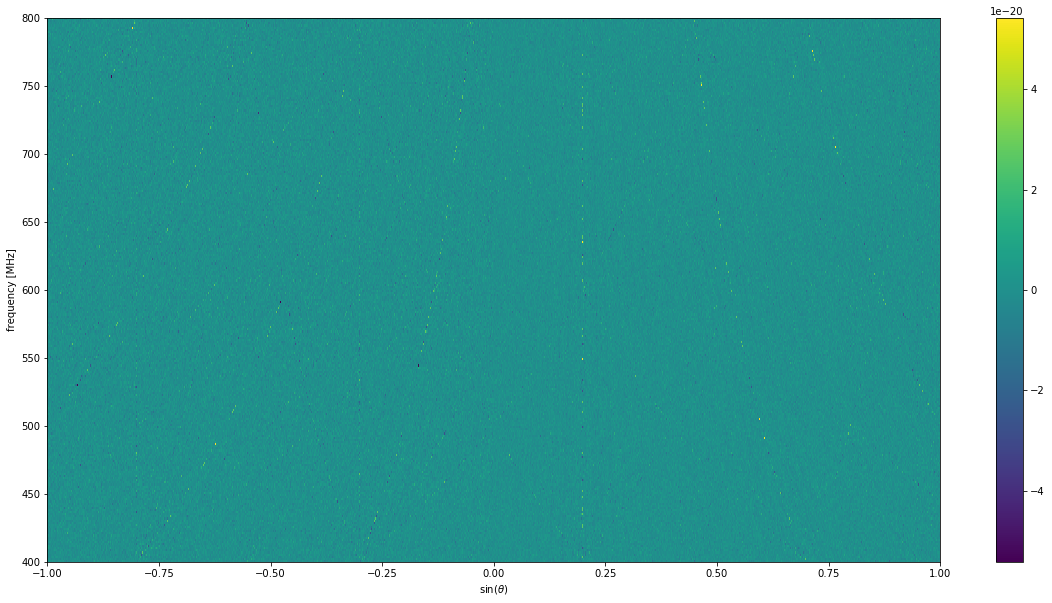

In [4]:
uvplane = t.uv2uvplane(uv1, indices=None)
rmap_no_error = t.get_obs_rmap(uvplane, time_error_sigma=0)

# Manually get rmap for no time errors
indices = (t.DoL2ndx(t.DoL)+0.5).astype(int)
rmap_obs = []
for i, f in enumerate(t.freqs):
    uvi = t.empty_uv()
    uvi[indices[i,:]] = uvplane[i,:]
    rmap_obs.append(t.uv2image(uvi))                                 
rmap_obs = np.array(rmap_obs)

# Is rmap_obs the same as rmap_no_error?
t.plot_rmap(rmap_obs - rmap_no_error)